# Calibration of the flooding model with gaussian linear least squares (BLUE)

The goal of this example is to calibrate the simulator associated with the flooding model with gaussian linear least squares. 



In [1]:
import openturns as ot
import numpy as np
import CalibrationAnalysis as ca

## Read the observations

We begin by reading the observations from the data file. There are 100 observations of the couple (Q,H).

In [2]:
observedSample = ot.Sample_ImportFromCSVFile("calibration_flooding_observations.csv")
nbobs = observedSample.getSize()
Qobs = observedSample[:,0]
Hobs = observedSample[:,1]
nbobs

100

In [3]:
Hobs.setDescription(["Height (m)"])

## Define the model

We define the model which has 4 inputs and one output H.

In [4]:
def functionFloodingModel(X):
    Q, K_s, Z_v, Z_m = X
    L = 5.0e3
    B = 300.0
    alpha = (Z_m - Z_v)/L
    H = (Q/(K_s*B*np.sqrt(alpha)))**(3.0/5.0)
    return [H]

In [5]:
modelPyFunc = ot.PythonFunction(4, 1, functionFloodingModel)
modelPyFunc.setDescription(["Q", "Ks", "Zv", "Zm","H"])

Define the value of the reference values of the $\theta$ parameter. In the bayesian framework, this is called the mean of the *prior* gaussian distribution. In the data assimilation framework, this is called the *background*.

In [6]:
KsInitial = 20.
ZvInitial = 49.
ZmInitial = 51.
thetaPrior = ot.Point([KsInitial,ZvInitial,ZmInitial])
thetaPrior.setDescription(("Ks","Zv","Zm"))

The following statement create the calibrated function from the model. The calibrated parameters Ks, Zv, Zm are at indices 1, 2, 3 in the inputs arguments of the model.

In [7]:
calibratedIndices = [1,2,3]
mycf = ot.ParametricFunction(modelPyFunc, calibratedIndices, thetaPrior)

## Calibration

The standard deviation of the observations.

In [8]:
sigmaH = 0.5 # (m^2)

Define the covariance matrix of the output Y of the model.

In [9]:
errorCovariance = ot.CovarianceMatrix(1)
errorCovariance[0,0] = sigmaH**2

Defined the covariance matrix of the parameters $\theta$ to calibrate.

In [10]:
sigmaKs = 5.
sigmaZv = 1.
sigmaZm = 1.

In [11]:
sigma = ot.CovarianceMatrix(3)
sigma[0,0] = sigmaKs**2
sigma[1,1] = sigmaZv**2
sigma[2,2] = sigmaZm**2
sigma

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[25,0,0,0,1,0,0,0,1]

The `BLUE` class performs the gaussian linear calibration by linearizing the model in the neighbourhood of the prior.

In [12]:
algo = ot.BLUE(mycf, Qobs, Hobs, thetaPrior, sigma, errorCovariance,"SVD")

The `run` method computes the solution of the problem.

In [13]:
algo.run()

In [14]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [15]:
thetaStar = calibrationResult.getParameterMAP()
thetaStar

class=Point name=Unnamed dimension=3 values=[24.5037,48.0993,51.9007]

In [16]:
mypcr = ca.CalibrationAnalysis(calibrationResult,mycf, Qobs,Hobs)

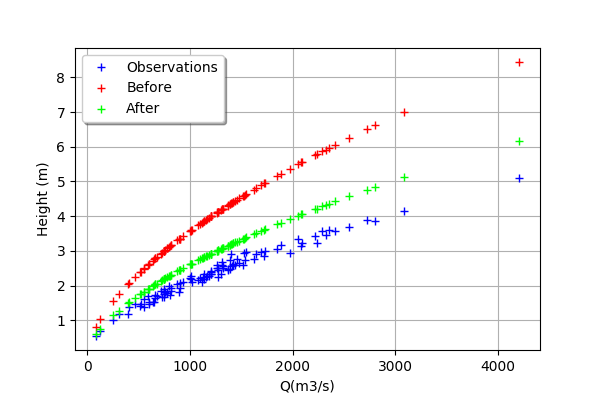

In [17]:
graph = mypcr.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
graph

We see that the output of the model after calibration is closer to the observations. However, there is still a distance from the outputs of the model to the observations. This indicates that the calibration cannot be performed with this method.

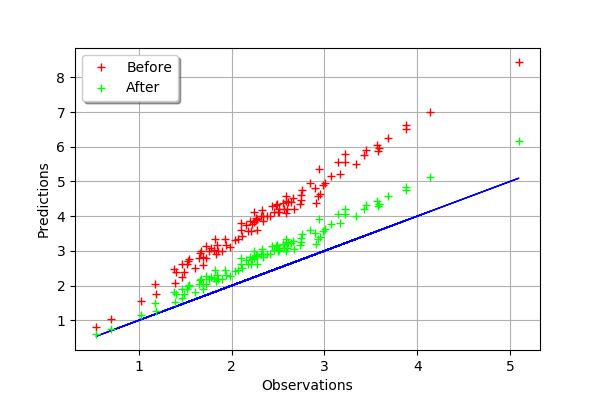

In [18]:
mypcr.drawObservationsVsPredictions()

In this case, the fit is better after calibration, but not perfect. Indeed, the cloud of points after calibration is not centered on the diagonal. 

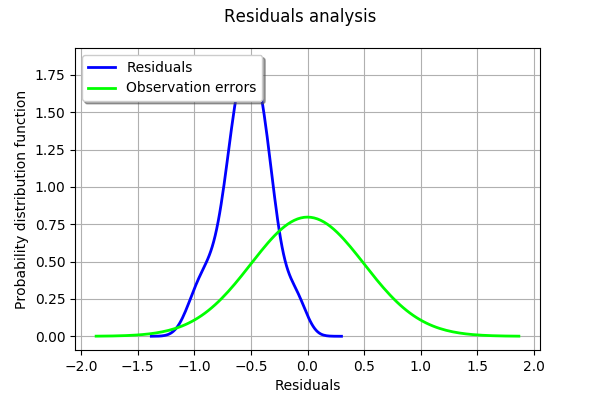

In [19]:
graph = mypcr.drawResiduals()
graph.setLegendPosition("topleft")
graph

We see that the distribution of the residual is not centered on zero: the mean residual is approximately -0.5, which implies that the predictions are, on average, smaller than the observations. This is a proof that the calibration cannot be performed with this method in this particular case.

The `getParameterPosterior` method returns the posterior gaussian distribution of $\theta$.

In [20]:
distributionPosterior = calibrationResult.getParameterPosterior()
distributionPosterior

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[24.5037,48.0993,51.9007] sigma=class=Point name=Unnamed dimension=3 values=[4.08465,0.816931,0.816931] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0.498407,-0.498407,0.498407,1,0.498407,-0.498407,0.498407,1]

We can compute a 95% confidence interval of the parameter $\theta^\star$.

In [21]:
distributionPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[14.9291,46.1843,49.9858] upper bound=class=Point name=Unnamed dimension=3 values=[34.0784,50.0142,53.8157] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

We see that there is a large uncertainty on the value of the parameter $K_s$ which can be as small as 14 and as large as 34. 

We can compare the prior and posterior distributions of the marginals of $\theta$. 

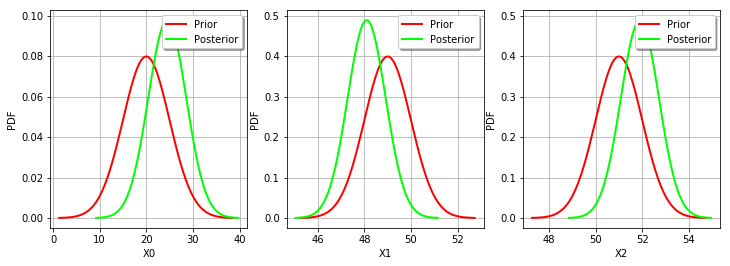

In [22]:
_ = mypcr.drawParameterDistributions()

The two distributions are different, which shows that the calibration is sensible to the observations (if the observations were not sensible, the two distributions were superimposed). Moreover, the two distributions are quite close, which implies that the prior distribution has played a roled in the calibration (otherwise the two distributions would be completely different, indicating that only the observations were taken into account). 